# River Network

In [1]:
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pynhd as nhd
from pynhd import NLDI, NHDPlusHR, WaterData

In [2]:
import warnings

warnings.filterwarnings("ignore")

[PyNHD](https://github.com/cheginit/pynhd) provides access to the Hydro Network-Linked Data Index ([NLDI](https://labs.waterdata.usgs.gov/about-nldi/index.html)) and the [WaterData](https://labs.waterdata.usgs.gov/geoserver/web/wicket/bookmarkable/org.geoserver.web.demo.MapPreviewPage?1) web services for navigating and subsetting [NHDPlus](https://nhdplus.com/NHDPlus) V2 database. Additionally, you can download NHDPlus High Resolution data as well.

First, let's get the watershed geometry of the contributing basin of a USGS station using `NLDI`:

In [3]:
nldi = NLDI()
station_id = "01031500"

basin = nldi.get_basins(station_id)

The `navigate_byid` class method can be used to navigate NHDPlus in both upstream and downstream of any point in the database. The available feature sources are ``comid``, ``huc12pp``, ``nwissite``, ``wade``, ``wqp``. Let's get ComIDs and flowlines of the tributaries and the main river channel in the upstream of the station.

In [4]:
flw_main = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamMain",
    source="flowlines",
    distance=1000,
)

flw_trib = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamTributaries",
    source="flowlines",
    distance=1000,
)

We can get other USGS stations upstream (or downstream) of the station and even set a distance limit (in km):

In [5]:
st_all = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamTributaries",
    source="nwissite",
    distance=1000,
)

st_d20 = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamTributaries",
    source="nwissite",
    distance=20,
)

Now, let's get the [HUC12 pour points](https://www.sciencebase.gov/catalog/item/5762b664e4b07657d19a71ea):

In [6]:
pp = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamTributaries",
    source="huc12pp",
    distance=1000,
)

Let's plot the vector data:

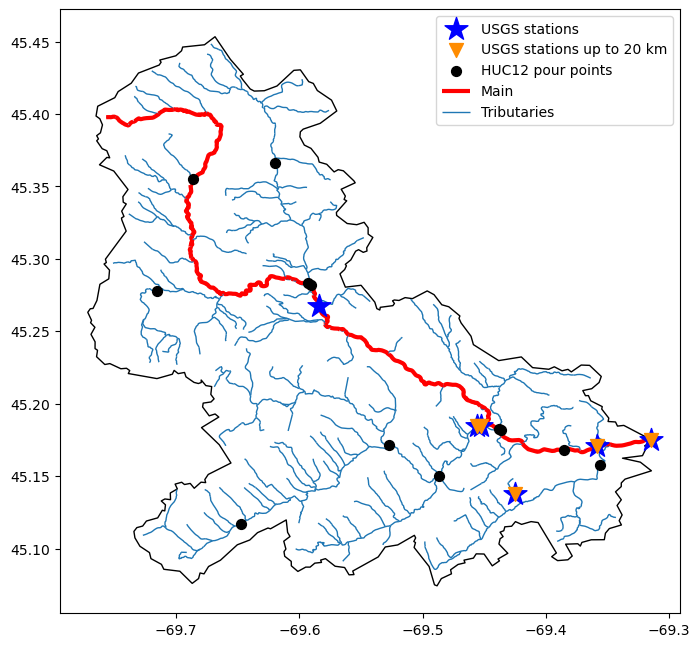

In [7]:
ax = basin.plot(facecolor="none", edgecolor="k", figsize=(8, 8))
st_all.plot(ax=ax, label="USGS stations", marker="*", markersize=300, zorder=4, color="b")
st_d20.plot(
    ax=ax,
    label="USGS stations up to 20 km",
    marker="v",
    markersize=100,
    zorder=5,
    color="darkorange",
)
pp.plot(ax=ax, label="HUC12 pour points", marker="o", markersize=50, color="k", zorder=3)
flw_main.plot(ax=ax, lw=3, color="r", zorder=2, label="Main")
flw_trib.plot(ax=ax, lw=1, zorder=1, label="Tributaries")
ax.legend(loc="best")
ax.set_aspect("auto")
ax.figure.set_dpi(100)
ax.figure.savefig("_static/nhdplus_navigation.png", bbox_inches="tight", facecolor="w")

Next, we get the slope data for each river segment from NHDPlus VAA database:

In [8]:
vaa = nhd.nhdplus_vaa("input_data/nhdplus_vaa.parquet")

flw_trib["comid"] = pd.to_numeric(flw_trib.nhdplus_comid)
slope = gpd.GeoDataFrame(
    pd.merge(flw_trib, vaa[["comid", "slope"]], left_on="comid", right_on="comid"),
    crs=flw_trib.crs,
)
slope[slope.slope < 0] = np.nan

<AxesSubplot:>

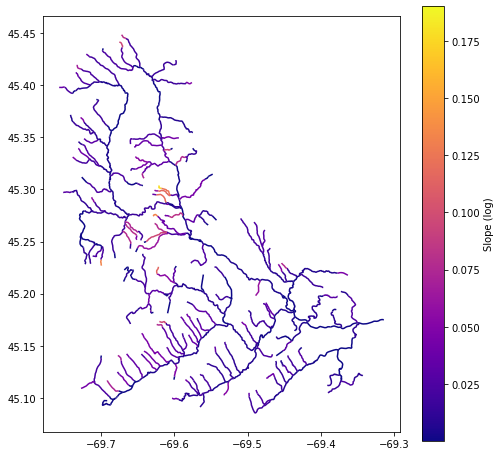

In [9]:
slope.plot(
    figsize=(8, 8),
    column="slope",
    cmap="plasma",
    legend=True,
    legend_kwds={"label": "Slope (log)"},
)

Now, let's use [WaterData](https://labs.waterdata.usgs.gov/geoserver/web/) service to get the headwater catchments for this basin:

In [10]:
wd_cat = WaterData("catchmentsp")
cat = wd_cat.bygeom(basin.geometry[0], predicate="OVERLAPS")

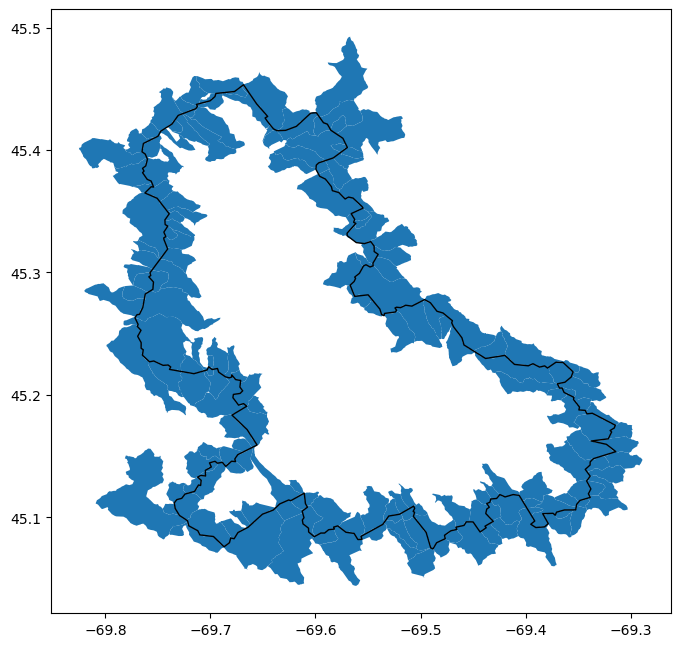

In [11]:
ax = cat.plot(figsize=(8, 8))
basin.plot(ax=ax, facecolor="none", edgecolor="k")
ax.set_aspect("auto")
ax.figure.set_dpi(100)

We might to get all the HUC12 pour points within a radius of an station. We can achieve this using `bydistance` method of `WaterData` class. For example, let's take station 01031300 and find all the flowlines within a radius of 5 km.

In [12]:
eck4 = "+proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
st300 = st_all[st_all.identifier == "USGS-01031300"].to_crs(eck4)
coords = st300.geometry.values[0].coords.xy
x, y = coords[0][0], coords[1][0]
rad = 5e3

In [13]:
nhdp_mr = WaterData("nhdflowline_network")

flw_rad = nhdp_mr.bydistance((x, y), rad, loc_crs=eck4)
flw_rad = flw_rad.to_crs(eck4)

Instead of getting all features within a radius of the coordinate, we can snap to the closest flowline using `NLDI`:

In [14]:
comid_closest = nldi.comid_byloc((x, y), eck4)
flw_closest = nhdp_mr.byid("comid", comid_closest.comid.values[0])

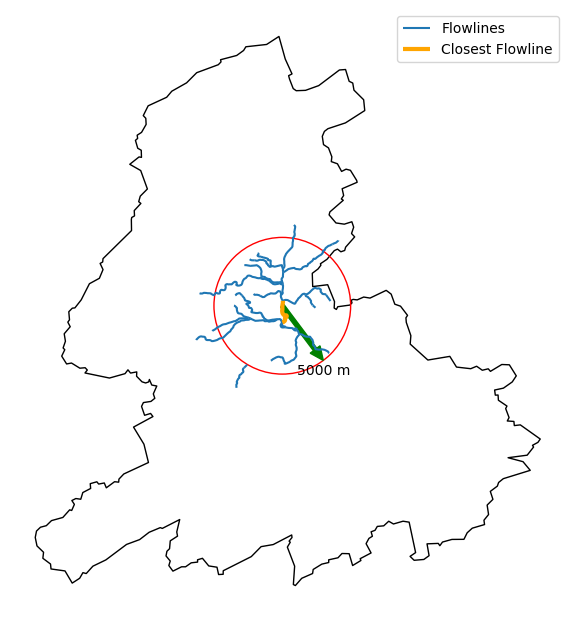

In [15]:
ax = basin.to_crs(eck4).plot(figsize=(8, 8), facecolor="none", edgecolor="k")
flw_rad.plot(ax=ax)
flw_closest.to_crs(eck4).plot(ax=ax, color="orange", lw=3)
ax.legend(["Flowlines", "Closest Flowline"])

circle = mpatches.Circle((x, y), rad, ec="r", fill=False)
arrow = mpatches.Arrow(x, y, 0.6 * rad, -0.8 * rad, 1500, color="g")
ax.text(x + 0.6 * rad, y + -rad, f"{int(rad)} m", ha="center")
ax.add_artist(circle)
ax.set_aspect("equal")
ax.add_artist(arrow)
ax.figure.set_dpi(100)
ax.axis("off")
ax.figure.savefig("_static/nhdplus_radius.png", bbox_inches="tight", facecolor="w")

`WaterData` gives us access to the medium-resolution NHDPlus database. We can use `NHDPlusHR` to retrieve high-resolution NHDPlus data. Let's get both medium- and high-resolution flowlines within the bounding box of our watershed and compare them. Moreover, Since several web services offer access to NHDPlus database, ``NHDPlusHR`` has an argument for selecting a service and also an argument for automatically switching between services.

In [16]:
flw_mr = nhdp_mr.bybox(basin.geometry[0].bounds)

nhdp_hr = NHDPlusHR("networknhdflowline", service="hydro", auto_switch=True)
flw_hr = nhdp_hr.bygeom(basin.geometry[0].bounds)

Found 3,860 features in the requested region.


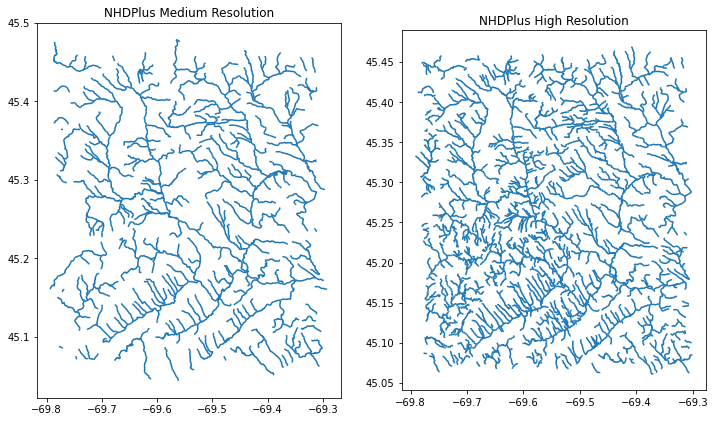

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), facecolor="w")

flw_mr.plot(ax=ax1)
ax1.set_title("NHDPlus Medium Resolution")
flw_hr.plot(ax=ax2)
ax2.set_title("NHDPlus High Resolution")
fig.savefig("_static/hr_mr.png", bbox_inches="tight", facecolor="w")

Since NHDPlus HR is still at the pre-release stage, let's use the MR flowlines to demonstrate the vector-based accumulation.

Based on a topological sorted river network ``pynhd.vector_accumulation`` computes flow accumulation in the network. It returns a dataframe which is sorted from upstream to downstream that shows the accumulated flow in each node.

PyNHD has a utility called ``prepare_nhdplus`` that identifies such relationship among other things such as fixing some common issues with NHDPlus flowlines. But first we need to get all the NHDPlus attributes for each ComID since `NLDI` only provides the flowlines' geometries and ComIDs which is useful for navigating the vector river network data. For getting the NHDPlus database we use ``WaterData``. The WaterData web service layers are  ``nhdflowline_network``, ``nhdarea``, ``nhdwaterbody``, ``catchmentsp``, ``gagesii``, ``huc08``, ``huc12``, ``huc12agg``, and ``huc12all``. Let's use the ``nhdflowline_network`` layer to get required info.

In [18]:
comids = [int(c) for c in flw_trib.nhdplus_comid.to_list()]
nhdp_trib = nhdp_mr.byid("comid", comids)
flw = nhd.prepare_nhdplus(nhdp_trib, 0, 0, purge_non_dendritic=False)

To demonstrate the use of routing, let's use `nhdplus_attrs` function to get list of available NHDPlus attributes from [Select Attributes for NHDPlus Version 2.1 Reach Catchments and Modified Network Routed Upstream Watersheds for the Conterminous United States](https://www.sciencebase.gov/catalog/item/5669a79ee4b08895842a1d47) item on `ScienceBase` service. These attributes are in catchment-scale and are available in three categories:

1. Local (`local`): For individual reach catchments,
2. Total (`upstream_acc`): For network-accumulated values using total cumulative drainage area,
3. Divergence (`div_routing`): For network-accumulated values using divergence-routed.

In [19]:
char_ids = nldi.get_validchars("local")
char_ids.head(5)

,characteristic_description,units,dataset_label,dataset_url,theme_label,theme_url,characteristic_type
CAT_WILDFIRE_2011,percent of wild fires per catchments for 2011,percent,Estimated percent of catchment that experience...,https://www.sciencebase.gov/catalog/item/57f66...,Land Cover,unknown,localCatch_name
CAT_CONTACT,Subsurface flow contact time index. The subsur...,days,"Contact time, the length of time it takes for ...",https://www.sciencebase.gov/catalog/item/56f96...,Hydrologic,https://www.sciencebase.gov/catalog/item/5669a...,localCatch_name
CAT_EWT,Average depth to water table relatice to the l...,meters,Average depth to water table relative to land ...,https://www.sciencebase.gov/catalog/item/56f97...,Hydrologic,https://www.sciencebase.gov/catalog/item/5669a...,localCatch_name
CAT_FUNGICIDE,Fungicide use on agricultural land in kilogram...,kilogram per square kilometer,Fungicide use on agricultural land in kilogram...,https://www.sciencebase.gov/catalog/item/56fd6...,Chemical,https://www.sciencebase.gov/catalog/item/56fd6...,localCatch_name
CAT_IEOF,Percentage of Horton overland flow as a percent,percent,Mean infiltration-excess overland flow as a pe...,https://www.sciencebase.gov/catalog/item/56f97...,Hydrologic,https://www.sciencebase.gov/catalog/item/5669a...,localCatch_name


Let's get Mean Annual Groundwater Recharge, ``RECHG``, using ``getcharacteristic_byid`` class method and carry out with the flow accumulation.

In [20]:
char = "CAT_RECHG"
area = "areasqkm"

local = nldi.getcharacteristic_byid(comids, "local", char_ids=char)
flw = flw.merge(local[char], left_on="comid", right_index=True)


def runoff_acc(qin, q, a):
    return qin + q * a


flw_r = flw[["comid", "tocomid", char, area]]
runoff = nhd.vector_accumulation(flw_r, runoff_acc, char, [char, area])


def area_acc(ain, a):
    return ain + a


flw_a = flw[["comid", "tocomid", area]]
areasqkm = nhd.vector_accumulation(flw_a, area_acc, area, [area])

runoff /= areasqkm

Since these are catchment-scale characteristic, let's get the catchments then add the accumulated characteristic as a new column and plot the results.

In [21]:
catchments = wd_cat.byid("featureid", comids)

c_local = catchments.merge(local, left_on="featureid", right_index=True)
c_acc = catchments.merge(runoff, left_on="featureid", right_index=True)

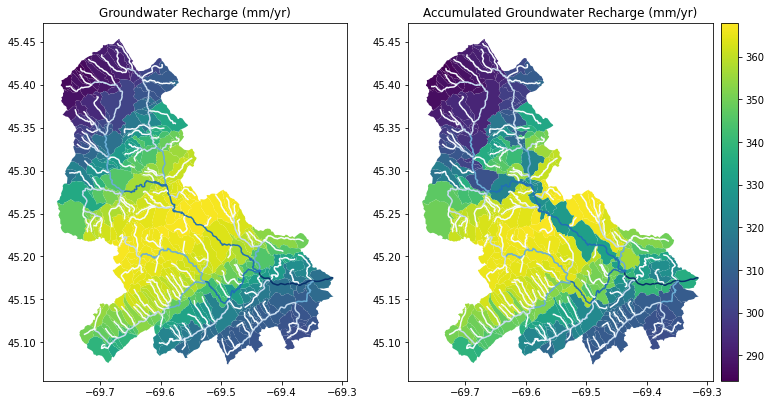

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), facecolor="w")

cmap = "viridis"
norm = plt.Normalize(vmin=c_local.CAT_RECHG.min(), vmax=c_acc.acc_CAT_RECHG.max())

c_local.plot(ax=ax1, column=char, cmap=cmap, norm=norm)
flw.plot(ax=ax1, column="streamorde", cmap="Blues", scheme="fisher_jenks")
ax1.set_title("Groundwater Recharge (mm/yr)")

c_acc.plot(ax=ax2, column=f"acc_{char}", cmap=cmap, norm=norm)
flw.plot(ax=ax2, column="streamorde", cmap="Blues", scheme="fisher_jenks")
ax2.set_title("Accumulated Groundwater Recharge (mm/yr)")

cax = fig.add_axes(
    [
        ax2.get_position().x1 + 0.01,
        ax2.get_position().y0,
        0.02,
        ax2.get_position().height,
    ]
)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, cax=cax)
fig.savefig("_static/flow_accumulation.png", bbox_inches="tight", facecolor="w")